In [ ]:
# default_exp eda

# Exploratory Data Analysis

> Data cleanup, imputation, feature engineering and visualization.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
from zipfile import ZipFile
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Data Retrieval

You can [get the dataset](https://www.kaggle.com/breana/bird-strikes) directly from Kaggle or use kaggle-cli. Both require a Kaggle login to download datasets. Use the inofficial Kaggle command line interface like so:

~~~
$ pip install kaggle-cli
$ kg download -u <username> -p <password> -c <competition>
~~~

For the data analysis, it is assumed the dataset `bird-strikes.zip` resides in `${pwd}/kaggle/`.

## Load Data

In [ ]:
with ZipFile('kaggle/bird-strikes.zip', 'r') as zf:
    zf.extractall('kaggle')
!ls kaggle

'Bird Strikes Test.csv'   bird-strikes.zip


`pandas` complains about mixed column types when processing the dataset in chunks (default). With `low_memory=False` the dataset is loaded all at once, apparently helping with guessing the proper column type.

In [ ]:
pd.options.display.max_columns = None
data = pd.read_csv('kaggle/Bird Strikes Test.csv', low_memory=False, parse_dates=True)
data.head(10)

,Airport: Name,Altitude bin,Aircraft: Make/Model,Effect: Impact to flight,FlightDate,Record ID,Effect: Indicated Damage,Aircraft: Number of engines?,Aircraft: Airline/Operator,Origin State,When: Phase of flight,Wildlife: Size,Wildlife: Species,When: Time (HHMM),When: Time of day,Pilot warned of birds or wildlife?,Cost: Aircraft time out of service (hours),Cost: Other (inflation adj),Cost: Repair (inflation adj),Cost: Total $,Miles from airport,Feet above ground,Speed (IAS) in knots
0,DETROIT METRO WAYNE COUNTY ARPT,< 1000 ft,A-319,NaN,1/1/2005 0:00,227413,No damage,2,NORTHWEST AIRLINES,Michigan,Climb,Medium,Unknown bird - medium,NaN,NaN,NaN,NaN,0,0,0,NaN,400,NaN
1,DANE COUNTY REGIONAL ARPT-TRUAX FLD,< 1000 ft,A-320,NaN,1/1/2005 0:00,226578,No damage,2,NORTHWEST AIRLINES,Wisconsin,Take-off run,Medium,Unknown bird - medium,NaN,NaN,NaN,NaN,0,0,0,0,0,NaN
2,HOGUE ARPT,< 1000 ft,PA-46 MALIBU,NaN,1/1/2005 0:00,268383,Caused damage,1,PRIVATELY OWNED,Tennessee,Landing Roll,Large,White-tailed deer,NaN,Day,NaN,NaN,0,0,0,0,0,20
3,SACRAMENTO INTL,< 1000 ft,B-737-300,None,1/1/2005 0:00,229514,Caused damage,2,SOUTHWEST AIRLINES,California,Approach,Large,Greater white-fronted goose,2140.0,Night,Y,NaN,0,"117,135","117,135",NaN,500,142
4,GUARULHOS INTL,< 1000 ft,B-767-300,NaN,1/1/2005 0:00,225661,No damage,2,UNITED AIRLINES,NaN,Landing Roll,Medium,Unknown bird - medium,NaN,NaN,NaN,NaN,0,0,0,0,0,NaN
5,HENDERSON FIELD,< 1000 ft,LOCKHEED C-130,Aborted Take-off,1/2/2005 0:00,230694,Caused damage,4,GOVERNMENT,Prince Edward Island,Take-off run,Large,Laysan albatross,1340.0,Day,Y,NaN,0,0,0,0,0,100
6,SAN FRANCISCO INTL ARPT,< 1000 ft,B-757-200,None,1/2/2005 0:00,234288,No damage,2,UNITED AIRLINES,California,Approach,Small,Unknown bird - small,507.0,Night,NaN,NaN,0,0,0,NaN,50,NaN
7,CLEVELAND-HOPKINS INTL ARPT,Unknown,UNKNOWN,NaN,1/2/2005 0:00,231042,No damage,NaN,UNKNOWN,Ohio,NaN,Medium,Herring gull,NaN,NaN,NaN,NaN,0,0,0,0,NaN,NaN
8,UNKNOWN,Unknown,A-300,None,1/2/2005 0:00,226234,No damage,2,ASTAR AIR CARGO,NaN,NaN,Medium,Unknown bird - medium,500.0,Night,NaN,1,53,0,53,NaN,NaN,NaN
9,ORLANDO INTL,< 1000 ft,B-757-200,None,1/2/2005 0:00,233011,No damage,2,DELTA AIR LINES,Florida,Landing Roll,Medium,Ring-billed gull,NaN,Day,N,NaN,0,0,0,0,0,100


## Data Summary

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65610 entries, 0 to 65609
Data columns (total 23 columns):
Airport: Name                                 65601 non-null object
Altitude bin                                  65610 non-null object
Aircraft: Make/Model                          65610 non-null object
Effect: Impact to flight                      36516 non-null object
FlightDate                                    65610 non-null object
Record ID                                     65610 non-null int64
Effect: Indicated Damage                      65610 non-null object
Aircraft: Number of engines?                  42766 non-null object
Aircraft: Airline/Operator                    65610 non-null object
Origin State                                  59163 non-null object
When: Phase of flight                         41051 non-null object
Wildlife: Size                                56684 non-null object
Wildlife: Species                             65593 non-null object
When: Ti

Which columns are missing data/incomplete? Note that this does not include the dataset's own chosen encoding of missing data for a given column.

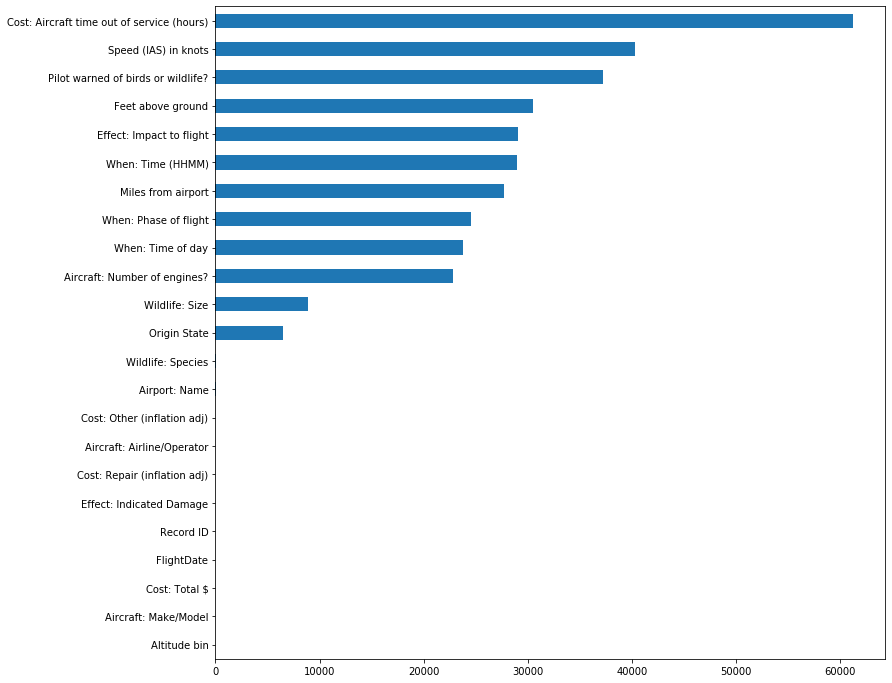

In [ ]:
data.isna().sum().sort_values().plot.barh(figsize=(12,12));

## Categorical Data

Let's look for categorical values. We can assume that categorical data has way fewer unique values than a column's total values. It's trivial to automate that assumption.

In [ ]:
#export

def findCategoricalCandidates(data:pd.DataFrame, ratio:float=0.01)->pd.DataFrame:
    result = pd.DataFrame(
        [(col, len(data[col].unique())) for col in data.columns],
        columns=['name', 'size']
    ).sort_values(by='size')
    
    n = len(data)
    return result[result['size'] / n < ratio]

For each categorical candidate, we'd like to have a tally for each possible category. This can show us problematic categories but also indicates columns that can be readily used for groupby/pivot tables. I use pd.DataFrame as a result type mainly for improved readability but also because it feels as if I was building my own database catalogue.

In [ ]:
#export

def categoricalTally(data:pd.DataFrame, cat_candidates:list, limit:int=10)->pd.DataFrame:
    result_cols = ['column'] + [f'cat{i:02d}' for i  in range(limit)]
    result = pd.DataFrame(columns=result_cols)
    
    index = 0
    for col in cat_candidates:    
        categories = data[col].unique()[:limit]
        result.loc[index] = ([col] + [(cat, len(data[data[col] == cat])) for cat in categories]
                                   + [None for i in range(len(categories), limit)])
        index += 1
        
    return result

In [ ]:
categoricalTally(data, findCategoricalCandidates(data)['name'])

,column,cat00,cat01,cat02,cat03,cat04,cat05,cat06,cat07,cat08,cat09
0,Effect: Indicated Damage,"(No damage, 61535)","(Caused damage, 4075)",None,None,None,None,None,None,None,None
1,Altitude bin,"(< 1000 ft, 27523)","(Unknown, 30541)","(> 1000 ft, 7546)",None,None,None,None,None,None,None
2,Pilot warned of birds or wildlife?,"(nan, 0)","(Y, 13100)","(N, 15261)",None,None,None,None,None,None,None
3,Wildlife: Size,"(Medium, 18064)","(Large, 3416)","(Small, 35204)","(nan, 0)",None,None,None,None,None,None
4,When: Time of day,"(nan, 0)","(Day, 25269)","(Night, 13623)","(Dusk, 1759)","(Dawn, 1207)",None,None,None,None,None
5,Effect: Impact to flight,"(nan, 0)","(None, 33247)","(Aborted Take-off, 594)","(Precautionary Landing, 1767)","(Other, 812)","(Engine Shut Down, 96)",None,None,None,None
6,Aircraft: Number of engines?,"(2, 37127)","(1, 2114)","(4, 1068)","(nan, 0)","(3, 2456)","(S, 1)",None,None,None,None
7,When: Phase of flight,"(Climb, 6317)","(Take-off run, 7239)","(Landing Roll, 7304)","(Approach, 16914)","(nan, 0)","(Taxi, 126)","(Descent, 1261)","(En Route, 1533)","(Parked, 42)","(Landing, 315)"
8,Miles from airport,"(nan, 0)","(0, 34610)","(12, 77)","(13, 13)","(20, 172)","(3, 341)","(8, 127)","(5, 394)","(50, 10)","(7, 121)"
9,Origin State,"(Michigan, 1373)","(Wisconsin, 695)","(Tennessee, 2097)","(California, 5278)","(nan, 0)","(Prince Edward Island, 97)","(Ohio, 2297)","(Florida, 3634)","(Louisiana, 1409)","(Georgia, 1083)"


## Data Repair & Cleanup

In [ ]:
data.describe()

,Record ID,When: Time (HHMM)
count,65610.000000,36636.000000
mean,246208.681116,1389.074271
std,80226.508941,613.410508
min,9005.000000,0.000000
25%,240765.250000,915.000000
50%,257226.500000,1410.000000
75%,303635.750000,1930.000000
max,322935.000000,2359.000000


Only two non-object columns is not what we expected from this dataset. Let's fix the columns that were parsed as strings but should have been numerical instead.

In [ ]:
for col in ['Speed (IAS) in knots', 'Feet above ground', 'Cost: Other (inflation adj)',
            'Cost: Aircraft time out of service (hours)', 'Cost: Other (inflation adj)',
            'Cost: Repair (inflation adj)', 'Cost: Total $']:
    data[col] = pd.to_numeric(data[col], errors='coerce')

In [ ]:
data.describe()

,Record ID,When: Time (HHMM),Cost: Aircraft time out of service (hours),Cost: Other (inflation adj),Cost: Repair (inflation adj),Cost: Total $,Feet above ground,Speed (IAS) in knots
count,65610.000000,36636.000000,4294.000000,65063.000000,64258.000000,64081.000000,26351.000000,25296.000000
mean,246208.681116,1389.074271,30.902422,2.069686,1.268745,2.786192,106.772912,144.463631
std,80226.508941,613.410508,102.120082,29.903886,26.112340,35.504005,199.300885,47.737767
min,9005.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,240765.250000,915.000000,0.000000,0.000000,0.000000,0.000000,0.000000,120.000000
50%,257226.500000,1410.000000,1.000000,0.000000,0.000000,0.000000,0.000000,140.000000
75%,303635.750000,1930.000000,10.000000,0.000000,0.000000,0.000000,100.000000,160.000000
max,322935.000000,2359.000000,984.000000,998.000000,984.000000,984.000000,995.000000,500.000000


## Data Imputation

(TODO)

## Preliminary Analysis

We want to know what contributes to an increased risk of bird strikes. We have useful categorical data. Mainly we look for clustering in our data. After-the-fact data such as `Cost: Aircraft time out of service (hours)` can be safely ignored. `Effect: {Impact to flight, Indicated Damage}` can be seen as our target variables, split over two columns. We can imagine multiple factors influencing the result:

* regionality: wildlife prefers some region over others,
* aircraft make/model: A Cesna is probably more affected by bird strikes than a Boeing 747,
* number of engines: Purely from a redundancy standpoint, more engines is likely to be better,
* altitude: birds fly at certain heights,
* altitude: aircraft could be more vulnerable at certain heights, with lower altitudes probably being riskier,
* time of day: wildlife has behavioural patterns,
* airline operators: some airline operators might service their aircrafts better than others, or use more reliable models,
* ...

Not all of the above mentioned factors increase the risk of a bird strike, however. In that sense, we can use the effect columns as indicators but not as final result. Also, the [FAA compiled a FAQ](https://www.faa.gov/airports/airport_safety/wildlife/faq/) that could help us understand the data. The [FAA's form to report bird strikes](https://wildlife.faa.gov/add) can give us clues as to why columns might have bad or unreliable data. 

## Analysis & Visualization

In [ ]:
data_ct = pd.crosstab([data['Origin State'], data['Airport: Name']], data['Effect: Impact to flight'], margins=True)
data_ct.sort_values(by='All', ascending=False)[1:].head(5)

,Effect: Impact to flight,Aborted Take-off,Engine Shut Down,None,Other,Precautionary Landing,All
Origin State,Airport: Name,,,,,,
Tennessee,MEMPHIS INTL,8,0,1129,5,14,1156
California,SACRAMENTO INTL,5,0,745,15,32,797
Kentucky,LOUISVILLE INTL ARPT,2,0,760,6,7,775
Texas,DALLAS/FORT WORTH INTL ARPT,10,3,725,17,16,771
Colorado,DENVER INTL AIRPORT,10,4,606,13,23,656


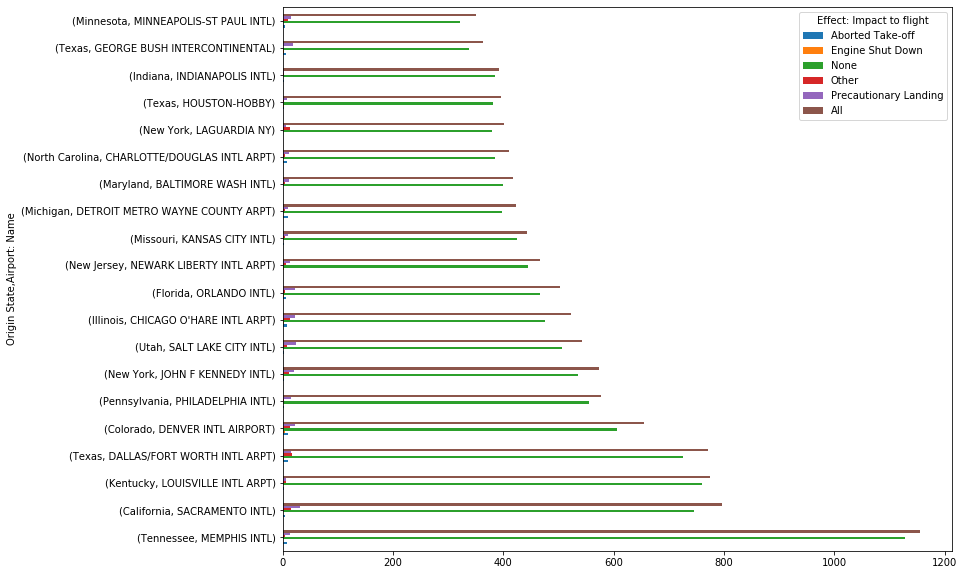

In [ ]:
data_ct.sort_values(by='All', ascending=False)[1:21].plot.barh(figsize=(12,10));

We can see that certain airports among the Top20, such as Memphis Intl or Sacramento Intl, report bird strikes at a higher rate.

## Correlation

As a first approach, a correlation matrix isn't going to produce much insight, simply because categorical columns are ignored in this analysis.

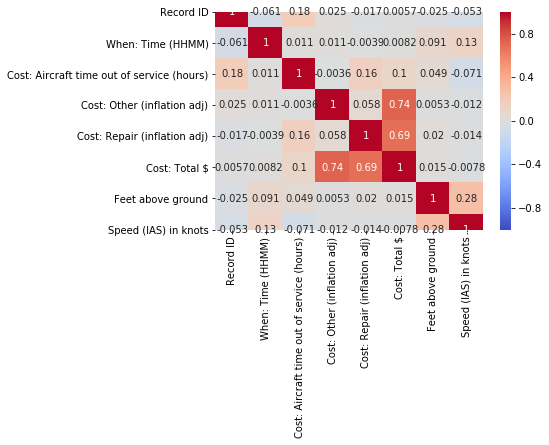

In [ ]:
sns.heatmap(data.corr(), cmap="coolwarm", annot=True, vmin=-1, vmax=1);